# Introduction to Q-learning

# Motivation: Digital Quantum Simulation

Goal: replicate the dynamics of a Hamiltonian using a quantum computer


$Q(s, a) = ...$

## Reinforcement learning 

- "agent" learning while interacting with an environment that return numerical rewards
- goal: take actions that maximize the reward
- algorithms: structured around estimating value functions

## Overview
- Introduction: the multi-armed bandit (exploration vs exploitation)
- Markov decision process
- Dynamical programming
- Monte-Carlo methods
- TD methods (with interactive Q-learning algorithm) 

# Multi-armed bandit

<img src="tako.png" width="600"/>

## Reinforcement learning vs other types of learning:
- uses  training  information  that evaluates the  actions  taken  rather  than instructs by  giving  correct actions.

## k-armed bandit:
- choose between k options (actions)
- receive a numerical reward chosen from a stationary probability distribution that depends on the action you selected 
- goal: maximize the expected total reward over many time steps.

## Action-value method
The value of an action is defined as $q_*(a) = \mathbb{E}(R_t | A_t = a) $

Simplest estimation of $q_*$ is $Q_t = \frac{\sum_{i=1}^{t-1} R_i \mathbb{1}_{A_i = a}}{\sum_{i=1}^{t-1} \mathbb{1}_{A_i = a}}$ : average of the rewards received for $a$.

## Exploitation vs Exploration
At a given time, the simplest action selection rule (also called a _policy_) is
$$A_t = {\underset{a}{\operatorname{argmax}}} \, Q_t(a)$$

This is the _greedy_ policy. It exploits current knowledge.
Dilemma: apparently inferior actions might actually be better.

Simple alternative: ___$\varepsilon$-greedy___ action selection
$$ A_t = \left\{ \begin{eqnarray} &{\rm random} \qquad &{\rm with \, \, prob} \, \, \varepsilon \\ &{\underset{a}{\operatorname{argmax}}} \, Q_t(a) \qquad &{\rm else} \end{eqnarray} \right.$$

This policy is central to a lot of reinforcement learning algorithms.


### 10-armed bandit testbed
For each arm $q_*(a)$ (the mean reward) is chosen randomly according to $\mathcal{N}(0, 1)$, and the rewards follow $\mathcal{N}(q_*(a), 1)$.

<IPython.core.display.Javascript object>


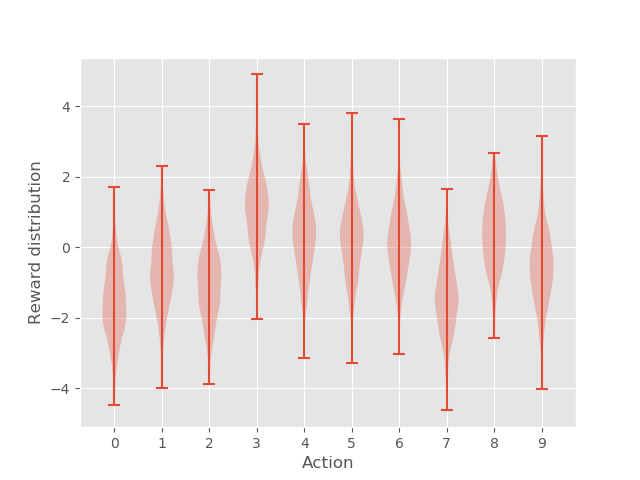

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib notebook
from tqdm import trange
from time import sleep

plt.violinplot(dataset=np.random.randn(1000, 10) + np.random.randn(10))
plt.xlabel("Action")
plt.ylabel("Reward distribution")
plt.xticks(range(1, 11), range(10))
plt.show()

In [3]:
class Bandit():
    
    def __init__(self, k, epsilon=0.0, seed=0):
        self.k = k
        self.epsilon = epsilon
        np.random.seed(seed)
        self.reset()
    
    def reset(self):
        self.time = 0
        # mean reward for each action (each arm)
        self.q_true = np.random.randn(self.k)
        self.best_action = np.argmax(self.q_true)
        # estimation for each action
        self.q_estimation = np.zeros(self.k)
        # count for each action
        self.action_count = np.zeros(self.k, dtype=int)
        
    def choose_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(np.arange(self.k))
        else:
            q_best = np.max(self.q_estimation)
            return np.random.choice(np.nonzero(self.q_estimation == q_best)[0])
        
    def step(self, action):
        self.time +=1
        # generate reward
        reward = np.random.randn() + self.q_true[action]
        self.action_count[action] += 1
        
        # incremental update (step size = 1/action_count)
        self.q_estimation[action] += (reward - self.q_estimation[action])/self.action_count[action]
        
        return reward

Simulating 4 10-arm bandits up to t=1000, 2000 times each.


100%|██████████| 2000/2000 [00:23<00:00, 88.48it/s]


<IPython.core.display.Javascript object>


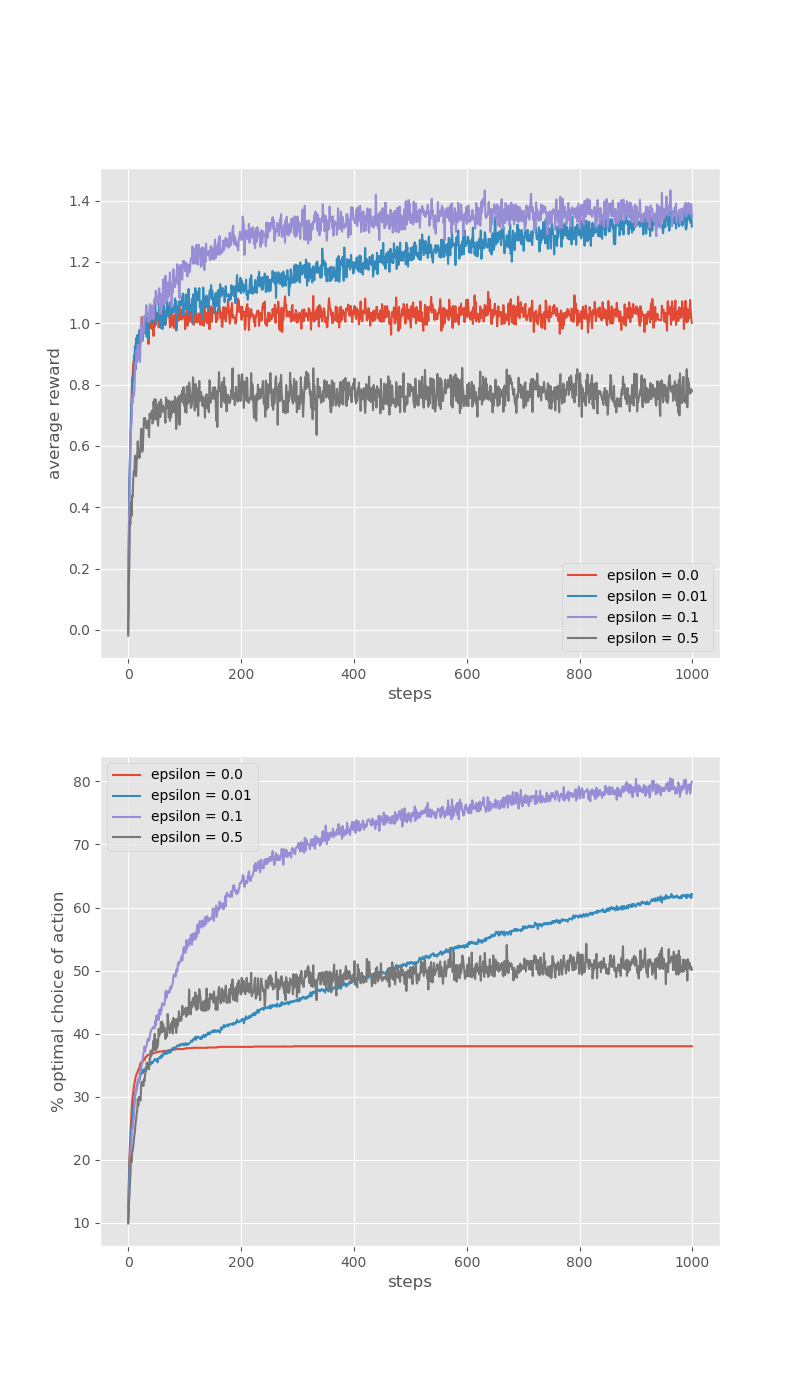

In [4]:
def simulate(n_runs, max_time, bandits):
    """n_runs (with different q_*) of all bandits up to t=max_time"""
    
    print(f"Simulating {len(bandits)} {bandits[0].k}-arm bandits up to t={max_time}, {n_runs} times each.")
    sleep(0.5)
    # track two metrics
    rewards = np.zeros((len(bandits), n_runs, max_time))
    optimal_choice_counts = np.zeros(rewards.shape)
    for i, bandit in enumerate(bandits):
        for run in trange(n_runs):
            bandit.reset()
            for time in range(max_time):
                action = bandit.choose_action()
                reward = bandit.step(action)
                rewards[i, run, time] = reward
                if action == bandit.best_action:
                    optimal_choice_counts[i, run, time] = 1
    mean_optimal_choice_counts = optimal_choice_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_optimal_choice_counts, mean_rewards


def bandit_figure(n_runs, max_time):
    epsilons = [0., 0.01, 0.1, 0.5]
    bandits = [Bandit(k=10, epsilon=eps) for eps in epsilons]
    optimal_choice_counts, rewards = simulate(n_runs, max_time, bandits)
    
    plt.style.use('ggplot')
    fig, ax = plt.subplots(2, 1, figsize=(8, 14))
    
    for eps, rewards, counts in zip(epsilons, rewards, optimal_choice_counts):
        ax[0].plot(rewards, label=f'epsilon = {eps}')
        ax[1].plot(100*counts, label=f'epsilon = {eps}')
    ax[0].set_xlabel('steps')
    ax[0].set_ylabel('average reward')
    ax[0].legend()
    ax[1].set_xlabel('steps')
    ax[1].set_ylabel('% optimal choice of action')
    ax[1].legend()
    
bandit_figure(n_runs=200, max_time=100)

# Markov Decision Processes

- __Sequential__ decision making: state of the environment change with action
- Actions influence not only the immediate rewards, but also the subsequent states $\rightarrow$ delayed rewards

## The Agent-Environment Interface

- At each time step $t$: agent receives information about the state $S_t \in \mathcal{S}$, chooses an action $A_t \in \mathcal{A}$. One time step later, the agent receives a reward $R_{t+1} \in \mathcal{R}$ and finds itself in a new state $S_{t+1}$.

<img src="agent-environment.png" width="600"/>

- MDP + agent give rise to trajectories $$S_0 \rightarrow A_0 \rightarrow R_1 \rightarrow S_1 \rightarrow A_1 \rightarrow R_2 \rightarrow S_2 ... $$

 
- dynamics of the MDP: $p(s', r \, | \, s, a) = {\rm Pr}(S_t = s', R_t = r \, | \, S_{t-1} = s, A_{t-1} = a)$ (can be deterministic)

- goal: maximize the delayed rewards or _return_ $G_t$
    - episodic tasks (terminal state reached at $t=T$) $$ G_t = R_{t+1} + R_{t+2} + \dots + R_T $$
    - continuing tasks $$ G_t = R_{t+1} + \gamma R_{t+2}  +  \gamma^2 R_{t+3} + \dots $$

## Policies and Value Functions

- As for the multi-armed bandit, we want to quantify the _value_ of choosing an action $a$.
- The choice depends on the state $s$ $\rightarrow$ like a different multi-armed bandit for each state.

The policy $\pi$ of the agent defines the probability $\pi(a \,|\, s)$ that $A_t =a$ if $S_t = s$.

For a given policy $\pi$, we can define
- The __value function__ of a state $s$: $$v_{\pi}(s) = \mathbb{E}_{\pi}[G_t \, | \, S_t = s] = \mathbb{E}_{\pi}[\sum_{i=0}^{\infty} \gamma^i R_{t+1+i} \, | \, S_t = s]$$

- The __action-value function__ (or _quality_ function) of an action $a$ given a state $s$: $$q_{\pi}(s, a) = \mathbb{E}_{\pi}[G_t \, | \, S_t = s, A_t = a] = \mathbb{E}_{\pi}[\sum_{i=0}^{\infty} \gamma^i R_{t+1+i} \, | \, S_t = s, A_t = a]$$


The value function satisfies a recursive equation, a __Bellman equation__

$$v_{\pi}(s) = \mathbb{E}_{\pi}[R_{t+1} + \gamma G_{t+1} \, | \, S_t = s] = \sum_a \pi(a \,|\, s) \sum_{s', r}p(s', r \,|\, s, a) \left[r + \gamma v_{\pi}(s')\right] $$


### optimal policy

Solving a reinforcement learning task $\approx$  finding a policy that achieves high rewards over the long run

An _optimal policy_ $\pi_*$ satisfies $v_{\pi_*}(s) \ge v_{\pi}(s)$ for all $s \in \mathcal{S}$ and all $\pi$. The __optimal value functions__ are then uniquely defined:

$$v_*(s) = \max_{\pi} v_{\pi}(s) \qquad \qquad q_*(s, a) = \max_{\pi} q_{\pi}(s, a)$$

which are related by

$$q_*(s, a) = \mathbb{E}[R_{t+1} + \gamma v_*(S_{t+1}) \, |\, S_t = s, A_t = a] \qquad v_*(s) = \max_a q_*(s, a)$$


Then, the greedy policy $\pi(a \,|\, s) = 1$ for $ a= {\underset{a'}{\operatorname{argmax}}} \, q_*(s, a')$ is an optimal policy.

### Bellman optimality equations

- Central to most RL algorithm.
- Written without explicit reference to any policy.

$$q_*(s, a) = \sum_{s', r'} p(s', r \,|\, s, a) \left[r + \gamma \max_{a'} q_*(s', a')\right] \qquad
v_*(s) = \max_{a}\sum_{s', r'} p(s', r \,|\, s, a) \left[r + \gamma v_*(s')\right]$$

For deterministic environments:

$$q_*(S_t, A_t) = R_{t+1} + \gamma \max_{a'} q_*(S_{t+1}, a') \qquad
v_*(S_t) = \max_{A_t}\left[R_{t+1} + \gamma v_*(S_{t+1})\right]$$

# Dynamic Programming

Key idea: use of value functions to organize and structure the search for good policies.

Two main steps:
- Policy __evaluation__ (or prediction problem):
    for a fixed policy $\pi$, compute an approximation of the value function $v_{\pi}(s)$ iteratively.

- Policy __improvement__:
    improve the policy $\pi \rightarrow \pi'$ such that $v_{\pi'}(s) \ge v_{\pi}(s)$ for all $s$.

## policy evaluation

Simple algorithm to evaluate $v_{\pi}(s)$:
1. Start with an arbitrary value function $v_0$ (e.g. all 0's)
2. Use the Bellman equation as an update rule: $$v_{k+1}(s) = \mathbb{E}_{\pi} \left[R_{t+1} + \gamma v_{k}(S_{t+1}) \,|\, S_t = s\right]$$

$\rightarrow$ $v_{\pi}$ is a fixed point for this update rule.

### Example: 4 x 4 gridworld with equiprobable random policy (deterministic transitions)


<img src="gridworld.png" width="600"/>

<IPython.core.display.Javascript object>


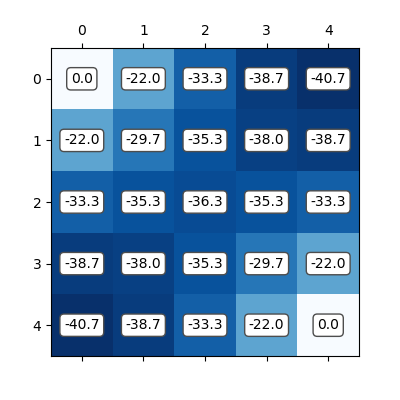

In [5]:
plt.style.use('default')

class Gridworld():
    
    def __init__(self, length, width):
        self.length = length
        self.width = width
        self.actions = np.array([[1, 0], [0, 1], [-1, 0], [0, -1]])
        self.prob = 0.25
        
    def step(self, state, action):
        """return a tuple (next_state, reward)"""
        if self.is_terminal(state):
            return state, 0
        
        next_state = state + action
        i, j = next_state
        if i < 0 or i >= self.length or j < 0 or j >= self.width:
            next_state = state
        reward = -1
        if self.is_terminal(next_state):
            reward = 0
        return next_state, reward
        
        
    def is_terminal(self, state):
        i, j = state
        return (i == 0 and j == 0) or (i == self.length-1 and j == self.width-1)
    
    
    def compute_value_function(self, discount_rate=1.0):
        step = 0
        value_function = np.zeros((self.length, self.width))
        while True:
            old_value_function = value_function.copy()
            for i in range(self.length):
                for j in range(self.width):
                    state = np.array([i, j])
                    value = 0
                    for action in self.actions:
                        (next_i, next_j), reward = self.step(state, action)
                        value += self.prob * (reward + discount_rate * value_function[next_i, next_j])
                    value_function[i, j] = value

            max_diff = abs(old_value_function - value_function).max()
            if max_diff < 1e-6:
                break
            step += 1
        
        self.value_function = value_function
        return value_function, step
    
    def draw_grid(self):
        fig, ax = plt.subplots(figsize=(4, 4))
        # Using matshow here just because it sets the ticks up nicely. imshow is faster.
        ax.matshow(self.value_function, cmap='Blues_r')
        for (i, j), value in np.ndenumerate(self.value_function):
            ax.text(j, i, f'{value:0.1f}', ha='center', va='center',
                    bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
        plt.show()



grid = Gridworld(5, 5)

grid.compute_value_function()
grid.draw_grid()

# The end

kk